In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [3]:
# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)
# Populate Bath cell with isotopes
diamond.add_isotopes(('13C', 0.011))
# Set z-direction of the bath (defect)
diamond.zdir = [1, 1, 1]
# Generate spin bath
### Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

# Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
# Setting up the Simulator

### Parameters of CCE calculations engine
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

In [88]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter
start = 2e2
stop = 1.88e6
num = 5

D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz

# D_list = [10] # Note for later, very low values of D give remarkably high coherence??

D_list = [19390]
print("D_list: ", D_list)
#############################################
# ZFS E parameter
E_start = -1e10
E_stop = 1e10
E_num = 5
E_list = np.linspace(E_start, E_stop, E_num)  # Replace these with your desired values

E = 0 # in kHz
##########################################################################################

coherence_list = []
coherence_dict = {}

for D in D_list:
    for E in E_list:
        # Define the central spin
        nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

        # The code already knows most exsiting isotopes.
        #              Bath spin types
        #              name    spin    gyro       quadrupole (for s>1/2)
        spin_types = [('14N',  1,      1.9338,    20.44),
                    ('13C',  1 / 2,  6.72828),
                    ('29Si', 1 / 2, -5.3188),]
        atoms.add_type(*spin_types)
        print(nv)

        # Setting the Simulator object
        ### Setting the runner engine
        calc = pc.Simulator(spin=nv, bath=atoms, D=D,
                            r_bath=r_bath, r_dipole=r_dipole, order=order)
        print(calc)
        # # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
        # nspin = calc.bath
        # # Set model quadrupole tensor at N atom
        # quad = np.asarray([[-2.5, 0, 0],
        #                    [0, -2.5, 0],
        #                    [0, 0,  5.0]]) * 1e3 * 2 * np.pi

        # nspin['Q'][nspin['N'] == '14N'] = quad
        print(calc)
        # Time points
        time_space = np.linspace(0, 2, 201)  # in ms
        # Number of pulses in CPMG seq (0 = FID, 1 = HE)
        n = 1

        ##########################################################################################
        # Mag. Field (Bx By Bz)
        b = np.array([0, 0, 0])  # in G
        ##########################################################################################

        # Hahn-echo pulse sequence
        pulse_sequence = [pc.Pulse('x',np.pi)]
        # pulse_sequence += [pc.Pulse('z',np.pi)]
        # pulse_sequence += [pc.Pulse('y',np.pi)]


        # Calculate coherence function
        l_generatilze = calc.compute(time_space, magnetic_field=b,
                                    pulses=pulse_sequence,
                                    method='gcce', quantity='coherence')
        
        # At the end of your inner loop:
        key = (D, E)
        coherence_dict[key] = l_generatilze

D_list:  [19390]
CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-1.00000e+10  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  9.99999e+09  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  1.29267e+04]]],
gyro:
[[[-17608.59705     -0.          -0.     ]
  [    -0.      -17608.59705     -0.     ]
  [    -0.          -0.      -17608.59705]]])
Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.

Simulator for center array of size 1.
magnetic field:
array([0., 0., 0.])

Parameters of cluster expansion:
r_bath: 40
r_dipole: 8
order: 2

Bath consists of 506 spins.

Clusters include:
506  clusters of order 1.
876  clusters of order 2.

CenterArray
(s: [1.],
xyz:
[[0. 0. 0.]],
zfs:
[[[-5.00001e+09  0.00000e+00  0.00000e+00]
  [ 0.00000e+00  4.99999e+09  0.00000e+00]
  [ 0.00000e+00  0.00000e+00  1.29267e+04]]],
gyro:
[

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


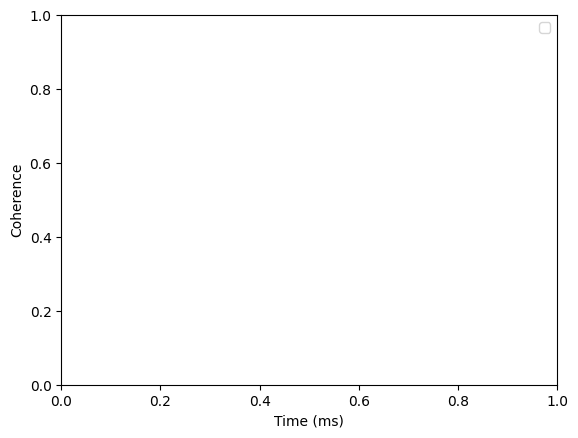

In [89]:
plt.figure()
for i in range(len(coherence_list)):
    plt.plot(time_space, coherence_list[i], label=f'D={D_list[i]}')
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.legend()
# plt.ylim(0,10)
plt.show()

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


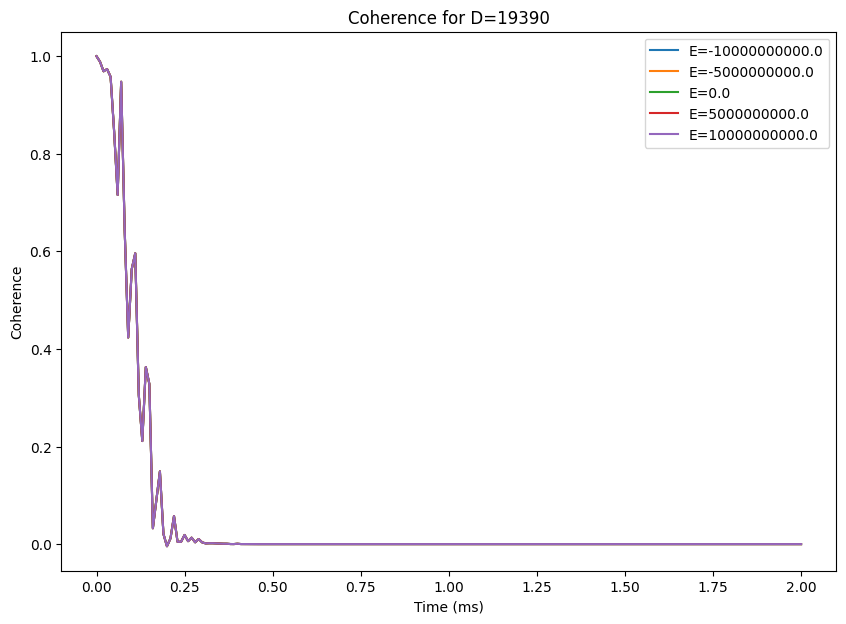

In [90]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Iterate over each unique D value
for D in unique_D_values:
    plt.figure(figsize=(10,7))
    for E in unique_E_values:
        coherence_for_DE = coherence_dict[(D, E)]
        plt.plot(time_space, coherence_for_DE, label=f'E={E}')
    
    plt.title(f'Coherence for D={D}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Coherence')
    plt.legend()
    plt.show()

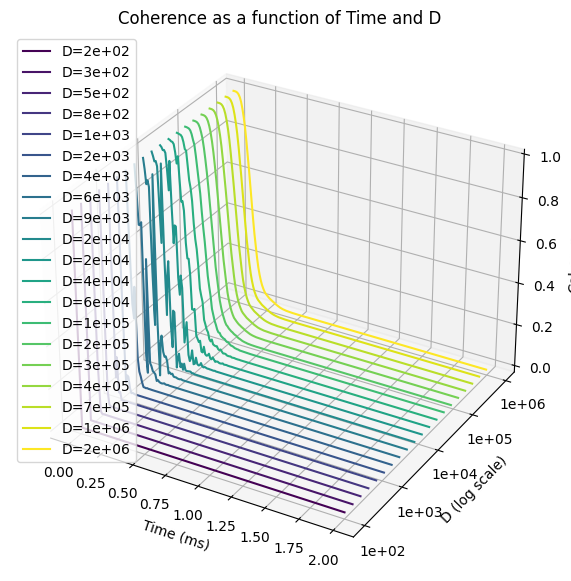

In [80]:
# On a 3d plot:


# Convert time_space and D_list to meshgrid
TIME, D = np.meshgrid(time_space, D_list)

# Convert coherence_list to a 2D numpy array
coherence_matrix = np.array(coherence_list)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each D value as an independent line
colors = plt.cm.viridis(np.linspace(0, 1, len(D_list)))
for i in range(len(D_list)):
    ax.plot(TIME[i], np.log10([D_list[i]] * len(TIME[i])), coherence_matrix[i], color=colors[i], label=f'D={D_list[i]:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(D_list)), np.log10(max(D_list)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D')
ax.legend()

plt.show()


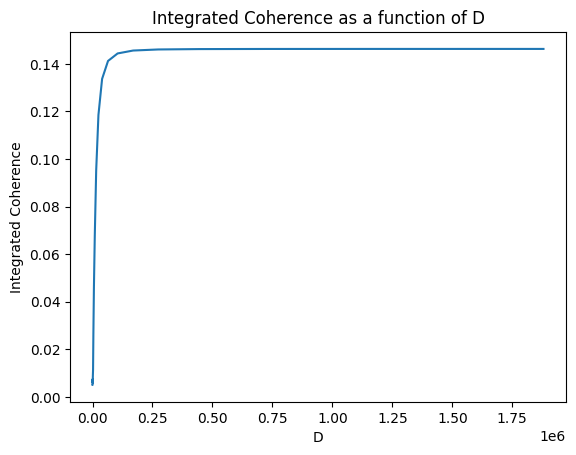

In [81]:
def integrate(x_list, y_list):
    """
    Integrate a list of y values with respect to a list of x values.
    """
    return np.trapz(y_list, x_list)

# Integrate each coherence curve
integrated_coherence = [integrate(time_space, coherence_list[i]) for i in range(len(coherence_list))]
# Plot the integrated coherence as a function of D
plt.figure()
plt.plot(D_list, integrated_coherence)
plt.xlabel('D')
plt.ylabel('Integrated Coherence')
plt.title('Integrated Coherence as a function of D')
plt.show()
